# **Text Summarizer**

## Pre-Processing and Classifiers

### Importing Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk    
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.callbacks as tkc
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Importing Data
#### This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories. We’ll take a sample of 10,000 reviews to reduce the training time of our model. 

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Reviews.csv",nrows=10000)

### Dropping Duplicates & Null Values

In [ ]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

### Preprocessing
#### Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

### Here is the dictionary that we will use for expanding the contractions:

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

### Text Cleaning

In [ ]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

### We will perform the below preprocessing tasks for our data:

##### Convert everything to lowercase
##### Remove HTML tags
##### Contraction mapping
##### Remove (‘s)
##### Remove any text inside the parenthesis ( )
##### Eliminate punctuations and special characters
##### Remove stopwords
##### Remove short words
### Let’s define the function:

In [ ]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

### Summary Cleaning

In [ ]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

### Defining the function for this task:

In [ ]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

### For Reference adding the START and END special tokens at the beginning and end of the summary

In [ ]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

### A look at the top 5 reviews and their summary

In [ ]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

# Feature Extraction and Analysis Techniques

## Understanding the distribution of the sequences

### Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

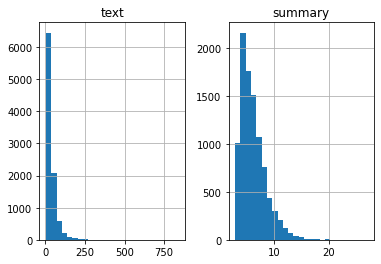

In [ ]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 25)
plt.show()

### From the above graphs, we can fix the maximum length of the reviews to 90 since that seems to be the majority review length. Similarly, we can set the maximum summary length to 10:

In [ ]:
max_len_text=90 
max_len_summary=10

### Before building the model, we need to split our dataset into a training and validation set. We’ll use 70% of the dataset as the training data and evaluate the performance on the remaining 30% (holdout set):

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.30,random_state=0,shuffle=True)

## Preparing the Tokenizer

### A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. 

In [ ]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)
 
#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

x_voc_size   =  len(in_tokenizer.word_index) +1
y_voc_size  =   len(tr_tokenizer.word_index) +1

# Model Building
## MODEL 1 - Stacked LSTM - New

## Few terms which are used in building the model below :-
#### Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep
#### Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only
#### Initial State: This is used to initialize the internal states of the LSTM for the first timestep
#### Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence.

### Here, we are building a 3 stacked LSTM for the encoder

In [ ]:
#pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_len_text, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_len_text, padding='post')
 
#decoder input data will not include the last word 
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_len_text,1)[:,1:]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 90, 500)      7426500     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 90, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

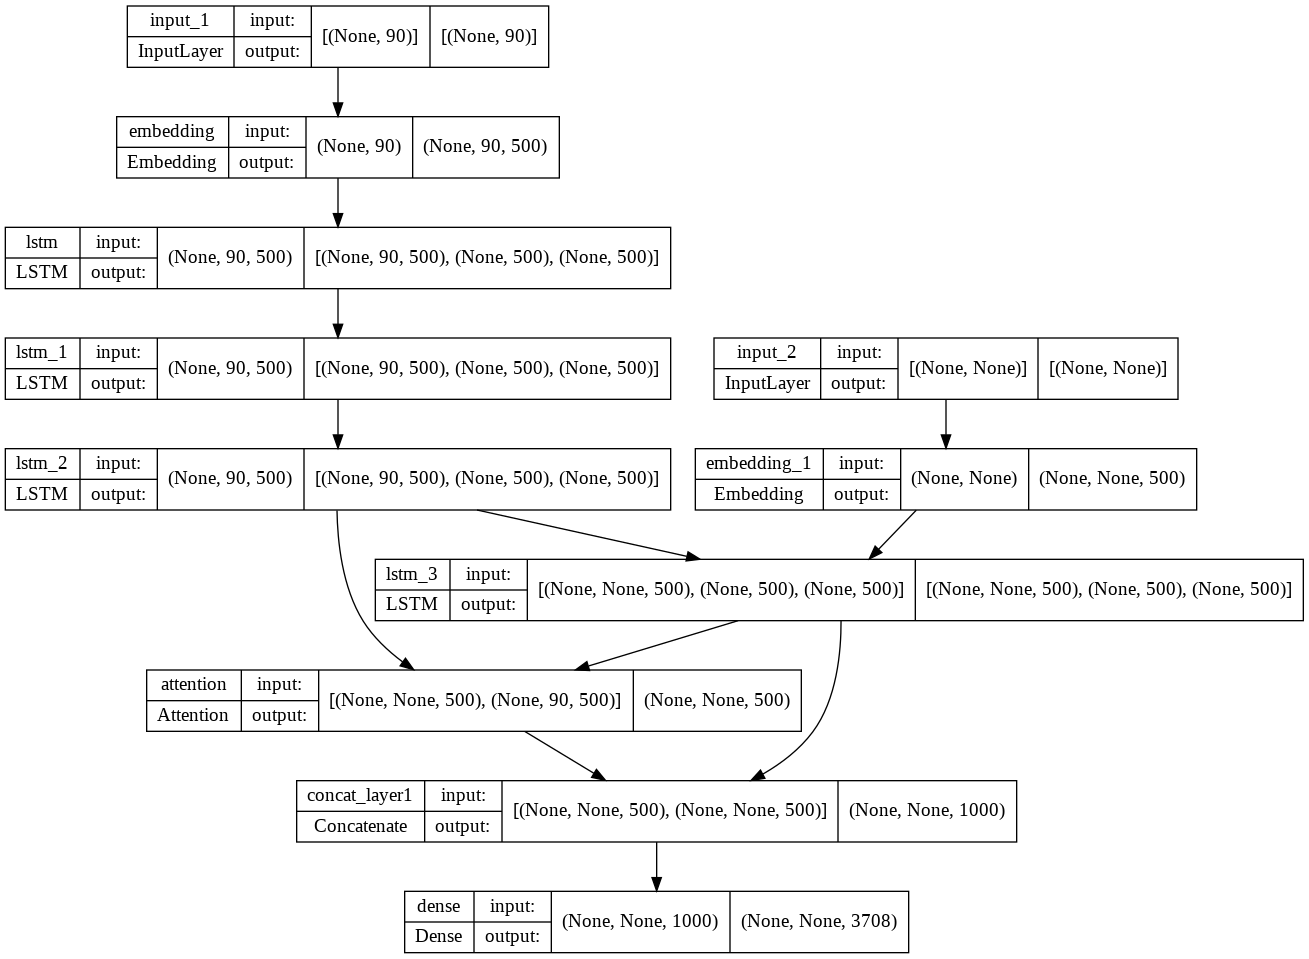

In [ ]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500
 
#create input object of total number of encoder words
en_inputs = Input(shape=(max_len_text,)) 
en_embedding = Embedding(x_voc_size, latent_dim)(en_inputs)


#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]

# Decoder. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

#Dense layer (output layer)
dec_dense = Dense(y_voc_size, activation='softmax') 
dec_outputs = dec_dense(merge)

#Model class and model summary for text Summarizer
model5 = Model([en_inputs, dec_inputs], dec_outputs) 
model5.summary()
plot_model(model5, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model5.compile( 
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 
history5 = model5.fit( 
    [en_in_data, dec_in_data],
    dec_tr_data, 
    batch_size=128, 
    epochs=10, 
    validation_split=0.3,
    )
 
#Save model
model5.save("/content/drive/MyDrive/Colab Notebooks/SavedModels/sLSTM_keras_save_model5.h5")

Epoch 1/10
37/37 [==============================] - 37s 685ms/step - loss: 0.7814 - accuracy: 0.9200 - val_loss: 0.3510 - val_accuracy: 0.9498
Epoch 2/10
37/37 [==============================] - 23s 635ms/step - loss: 0.3295 - accuracy: 0.9541 - val_loss: 0.3222 - val_accuracy: 0.9564
Epoch 3/10
37/37 [==============================] - 23s 638ms/step - loss: 0.3029 - accuracy: 0.9570 - val_loss: 0.3128 - val_accuracy: 0.9570
Epoch 4/10
37/37 [==============================] - 24s 640ms/step - loss: 0.2911 - accuracy: 0.9574 - val_loss: 0.3141 - val_accuracy: 0.9573
Epoch 5/10
37/37 [==============================] - 24s 639ms/step - loss: 0.2846 - accuracy: 0.9576 - val_loss: 0.3098 - val_accuracy: 0.9574
Epoch 6/10
37/37 [==============================] - 23s 637ms/step - loss: 0.2769 - accuracy: 0.9580 - val_loss: 0.3086 - val_accuracy: 0.9577
Epoch 7/10
37/37 [==============================] - 23s 637ms/step - loss: 0.2686 - accuracy: 0.9583 - val_loss: 0.3038 - val_accuracy: 0.9579

# Graphs

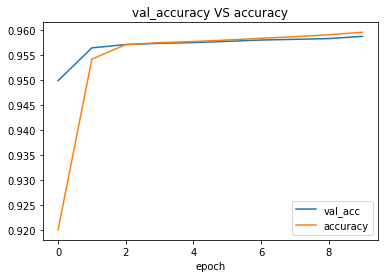

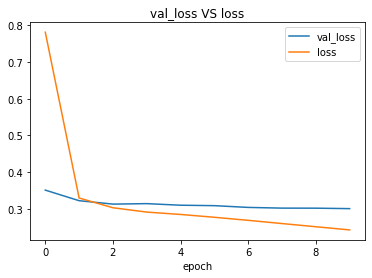

In [ ]:
from matplotlib import pyplot
pyplot.plot(history5.history['val_accuracy'])
pyplot.plot(history5.history['accuracy'])
pyplot.title('val_accuracy VS accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['val_acc', 'accuracy'], loc='lower right')
pyplot.show()

pyplot.plot(history5.history['val_loss'])
pyplot.plot(history5.history['loss'])
pyplot.title('val_loss VS loss')
pyplot.xlabel('epoch')
pyplot.legend(['val_loss', 'loss'], loc='upper right')
pyplot.show()

# Inference of the Model


In [ ]:
# encoder inference
latent_dim=500
#/content/gdrive/MyDrive/Text Summarizer/
#load the model
model5 = models.load_model("/content/drive/MyDrive/Colab Notebooks/SavedModels/sLSTM_keras_save_model5.h5")
 
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model5.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model5.input[0],[en_outputs]+en_states)

In [ ]:
# decoder inference
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_len_text,latent_dim))
 
# Get the embeddings and input layer from the model
dec_inputs = model5.input[1]
dec_emb_layer = model5.layers[5]
dec_lstm = model5.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

In [ ]:
#Attention layer
attention = model5.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

In [ ]:
#Dense layer
dec_dense = model5.layers[10]
dec_outputs2 = dec_dense(merge2)
 
# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

In [ ]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index
reverse_target_word_index[0]=' '
 
def decode_sequence(input_seq):
    #get the encoder output and states by passing the input sequence
    en_out, en_h, en_c= en_model.predict(input_seq)
 
    #target sequence with initial word as 'start'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['start']
 
    #if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    #append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition: 
        #get predicted output, hidden and cell state.
        output_words, dec_h, dec_c= dec_model.predict([target_seq] + [en_out,en_h, en_c])
        
        #get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word +" "
        # Exit condition: either hit max length
        # or find a stop word or last word.
        if "end" in input_seq or len(decoded_sentence) > max_len_text:
          stop_condition = True
        #update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c
    #return the decoded sentence
    return decoded_sentence

# Output

In [ ]:
inp_review = input("Enter : ")
inp_review = ' '.join(inp_review)
inp_x= in_tokenizer.texts_to_sequences([inp_review]) 
inp_x= pad_sequences(inp_x,  maxlen=max_len_text, padding='post')
 
summary=decode_sequence(inp_x.reshape(1,max_len_text))
if 'end' in summary :
  summary=summary.replace('end','')
print("\nPredicted summary:",summary);
print("\n")

Enter : I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Predicted summary: very good                                                                                




# Performance Analysis
## 1. Confusion Matrix
## 2. Classification Report

In [ ]:
y_pred1 = model.predict([x_val,y_val[:,:-1]])
y_pred1.flatten()
y_pred1.round(2)
z= np.argmax(y_pred1, axis=1)
z = np.delete(z, np.s_[0:3707], 1)
z.reshape(124,23)

[[8 0 3 ... 2 0 0]
 [6 3 4 ... 1 3 3]
 [5 1 3 ... 1 2 0]
 ...
 [4 6 8 ... 3 6 3]
 [5 1 3 ... 1 2 2]
 [7 2 3 ... 0 2 0]]


In [ ]:
a = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]
ac = np.argmax(a, axis=1)
ac.reshape(124,23)

array([[3, 3, 2, ..., 3, 0, 0],
       [0, 2, 1, ..., 4, 0, 0],
       [2, 2, 0, ..., 1, 3, 0],
       ...,
       [0, 0, 0, ..., 5, 1, 2],
       [6, 3, 4, ..., 0, 2, 6],
       [0, 1, 2, ..., 3, 0, 2]])

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot
cf_matrix1 = confusion_matrix(ac, z)
cf_matrix1

array([[701, 107,  89,  64,  20,   4,   6,   2,   0],
       [510, 129,  52,  52,  39,   3,   3,   0,   0],
       [201,  44,  99,  35,  19,  10,   6,   1,   0],
       [101,  35,  32,  88,  24,   3,   7,   1,   0],
       [ 35,  12,  19,  45,  34,   2,   2,   4,   0],
       [ 27,  15,   5,  17,  17,  24,   2,   1,   1],
       [ 13,   6,   8,   6,   9,   9,   9,   1,   0],
       [  1,   8,   8,   6,   8,   4,   2,   5,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0]])

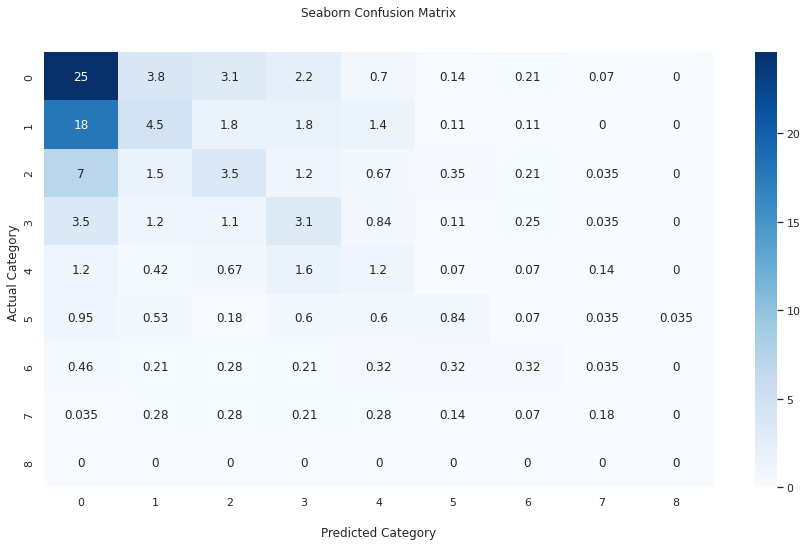

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
ax1 = sns.heatmap((cf_matrix1/np.sum(cf_matrix1)*100), annot=True, cmap='Blues', cbar=True)

ax1.set_title('Seaborn Confusion Matrix\n\n');
ax1.set_xlabel('\nPredicted Category')
ax1.set_ylabel('Actual Category ');
## Display the visualization of the Confusion Matrix.
pyplot.show()

In [ ]:
from sklearn.metrics import classification_report
class_report1 = classification_report(ac, z)
print(class_report1)

              precision    recall  f1-score   support

           0       0.44      0.71      0.54       993
           1       0.36      0.16      0.23       788
           2       0.32      0.24      0.27       415
           3       0.28      0.30      0.29       291
           4       0.20      0.22      0.21       153
           5       0.41      0.22      0.29       109
           6       0.24      0.15      0.18        61
           7       0.33      0.12      0.18        42
           8       0.00      0.00      0.00         0

    accuracy                           0.38      2852
   macro avg       0.29      0.24      0.24      2852
weighted avg       0.36      0.38      0.35      2852



# Model Building 2

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.30,random_state=0,shuffle=True) 

### a) Text Tokenizer

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

### b) Summary Tokenizer

In [ ]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

## MODEL 1 - Stacked LSTM - Old

In [ ]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_output3, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
dec_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
#attention = Attention()
attn_out = Attention()([dec_outputs,encoder_output3])

# Concat attention output and decoder LSTM output 
merge = Concatenate(axis=-1, name='concat')([dec_outputs])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(merge) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 90, 500)      7426500     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 90, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

### We are using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector(This overcomes any memory issues).

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Early Stopping - It is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, we are monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)

### We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 2% of our dataset)

In [ ]:
#SAVED_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/SavedModels/sLSTM"
#cbk = tkc.ModelCheckpoint(filepath=SAVED_MODEL_PATH, save_weights_only=False, monitor="loss", mode="min", save_best_only=True)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=18,batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]), callbacks=[es])

Epoch 1/18
52/52 [==============================] - 47s 428ms/step - loss: 3.4513 - accuracy: 0.5248 - val_loss: 2.6969 - val_accuracy: 0.6150
Epoch 2/18
52/52 [==============================] - 20s 390ms/step - loss: 2.8646 - accuracy: 0.5934 - val_loss: 2.5974 - val_accuracy: 0.6161
Epoch 3/18
52/52 [==============================] - 20s 393ms/step - loss: 2.7542 - accuracy: 0.5977 - val_loss: 2.5444 - val_accuracy: 0.6207
Epoch 4/18
52/52 [==============================] - 20s 394ms/step - loss: 2.6557 - accuracy: 0.6015 - val_loss: 2.4992 - val_accuracy: 0.6241
Epoch 5/18
52/52 [==============================] - 21s 398ms/step - loss: 2.5505 - accuracy: 0.6068 - val_loss: 2.4609 - val_accuracy: 0.6276
Epoch 6/18
52/52 [==============================] - 20s 393ms/step - loss: 2.4537 - accuracy: 0.6127 - val_loss: 2.4394 - val_accuracy: 0.6299
Epoch 7/18
52/52 [==============================] - 20s 394ms/step - loss: 2.3573 - accuracy: 0.6189 - val_loss: 2.4073 - val_accuracy: 0.6342

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/SavedModels/sLSTM_keras_save.h5")

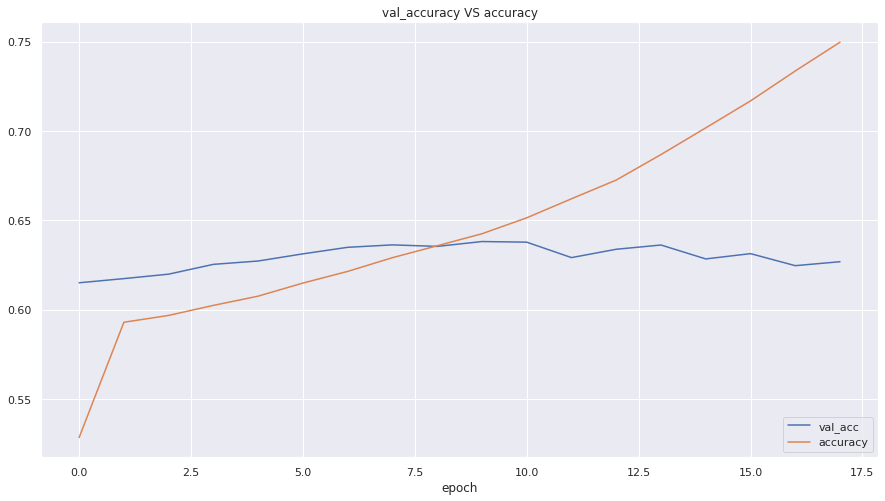

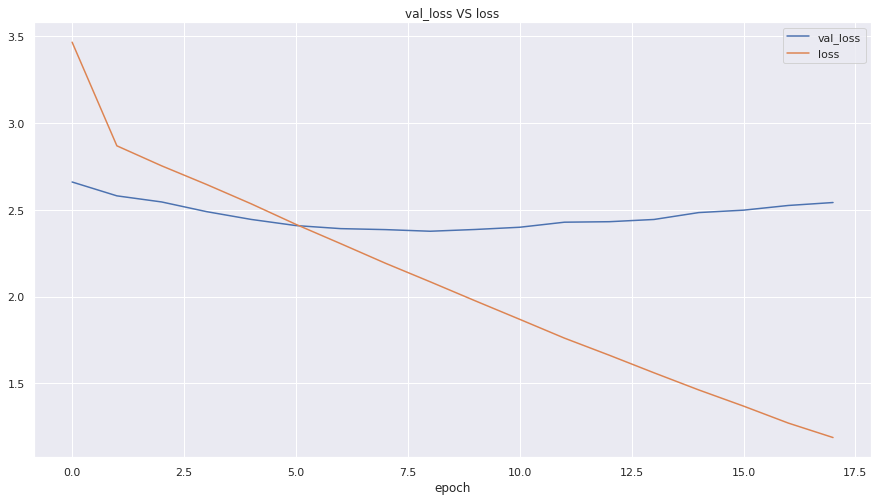

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['val_accuracy'])
pyplot.plot(history.history['accuracy'])
pyplot.title('val_accuracy VS accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['val_acc', 'accuracy'], loc='lower right')
pyplot.show()

pyplot.plot(history.history['val_loss'])
pyplot.plot(history.history['loss'])
pyplot.title('val_loss VS loss')
pyplot.xlabel('epoch')
pyplot.legend(['val_loss', 'loss'], loc='upper right')
pyplot.show()

In [ ]:
from keras.models import load_model
model_slstm = load_model("/content/drive/MyDrive/Colab Notebooks/SavedModels/sLSTM_keras_save.h5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 90, 500)      7426500     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 90, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

# Inference Model
### **Here we were getting a Runtim Error in the output so we created a new model (Above this Model)**

Let’s build the dictionary to convert the index to word for target and source vocabulary:

In [ ]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

Set up the inference for the encoder and decoder:

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_output3, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attn_out = Attention()([dec_outputs,encoder_output])
attn_out_inf, attn_states_inf = Attention()([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
# encoder inference
#load the model
from keras.models import load_model
model1 = load_model("/content/drive/MyDrive/Colab Notebooks/SavedModels/sLSTM_keras_save.h5")
latent_dim=500
 
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model1.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model1.input[0],[en_outputs]+en_states)


In [ ]:
# decoder inference
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_len_text,latent_dim))
 
# Get the embeddings and input layer from the model
dec_inputs = model1.input[1]
dec_emb_layer = model1.layers[5]
dec_lstm = model1.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

In [ ]:
#Attention layer
attention = model1.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

In [ ]:
#Dense layer
dec_dense = model1.layers[10]
dec_outputs2 = dec_dense(merge2)
 
# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(10):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: energy chews absolutely delicious hold really well pocket backpack backpacking mountain biking really could imagine eating energy chew ever 
Original summary: love these energy chews 
Predicted summary:  occassions expecting diversion arriba arriba there haven rubies rubies


Review: went grocery stores looking flavor jello green tomato jam recipe finally found jello wonderful carried stores summer harvest time fall could find anywhere town jello tastes like watermelon jam recipe made takes like watermelon jam great made regular jello yummy 
Original summary: great flavor of jell 
Predicted summary:  occassions expecting diversion arriba arriba there haven rubies rubies


Review: minutes feel alot relaxed reminded smoking certain item younger tastes great boot 
Original summary: going into koma 
Predicted summary:  occassions expecting diversion arriba arriba there haven rubies rubies


Review: salty way tough gave shot anyway know ordered different flavor got lucky nonetheless

## MODEL 2 - Bi Directional LSTM

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.3,random_state=0,shuffle=True)
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')


from keras import backend as K2
K2.clear_session()
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

embedding_dim=200
latent_dim=200

#(x_train, y_train),(x_test, y_test) = Input(shape=(max_len_text,))
x_tr = sequence.pad_sequences(x_tr, maxlen=max_len_text, padding='post')
x_val = sequence.pad_sequences(x_val, maxlen=max_len_text, padding='post')
y_tr = np.asarray(y_tr).astype('float32')
y_var = np.asarray(y_val).astype('float32')

model2 = Sequential()
model2.add(Embedding(embedding_dim, latent_dim, input_length=max_len_text))

In [ ]:
model2.add(Bidirectional(LSTM(64)))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
es2 = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)

In [ ]:
#SAVED_MODEL_PATH_2 = "/content/drive/MyDrive/Colab Notebooks/SavedModels/BiLSTM"
#cbk2 = tkc.ModelCheckpoint(filepath=SAVED_MODEL_PATH_2, save_weights_only=False, monitor="accuracy", mode="max", save_best_only=True)

In [ ]:
history2=model2.fit(x_tr, y_tr, batch_size=128, epochs=50, validation_data=[x_val, y_val], callbacks=[es2])

Epoch 1/50
52/52 [==============================] - 10s 104ms/step - loss: -706.4315 - accuracy: 0.2375 - val_loss: -1231.5055 - val_accuracy: 0.2756
Epoch 2/50
52/52 [==============================] - 4s 68ms/step - loss: -2354.1882 - accuracy: 0.2462 - val_loss: -2232.3101 - val_accuracy: 0.2756
Epoch 3/50
52/52 [==============================] - 3s 57ms/step - loss: -3607.9983 - accuracy: 0.2447 - val_loss: -3109.7578 - val_accuracy: 0.2756
Epoch 4/50
52/52 [==============================] - 3s 51ms/step - loss: -4770.5181 - accuracy: 0.2567 - val_loss: -3957.9502 - val_accuracy: 0.2756
Epoch 5/50
52/52 [==============================] - 2s 48ms/step - loss: -5916.3999 - accuracy: 0.2519 - val_loss: -4772.9585 - val_accuracy: 0.2756
Epoch 6/50
52/52 [==============================] - 2s 45ms/step - loss: -7004.8169 - accuracy: 0.2500 - val_loss: -5577.0752 - val_accuracy: 0.2756
Epoch 7/50
52/52 [==============================] - 3s 49ms/step - loss: -8122.5747 - accuracy: 0.2570 - 

In [ ]:
model2.save("/content/drive/MyDrive/Colab Notebooks/SavedModels/BiLSTM_keras_save.h5")

In [ ]:
from keras.models import load_model
model_bilstm = load_model("/content/drive/MyDrive/Colab Notebooks/SavedModels/BiLSTM_keras_save.h5")
model_bilstm.summary()
score2 = model_bilstm.evaluate(x_tr, y_tr, verbose=0)
print("%s: %.2f%%" % (model_bilstm.metrics_names[1], score2[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 90, 200)           40000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 176,970
Trainable params: 176,970
Non-trainable params: 0
_________________________________________________________________
accuracy: 27.42%


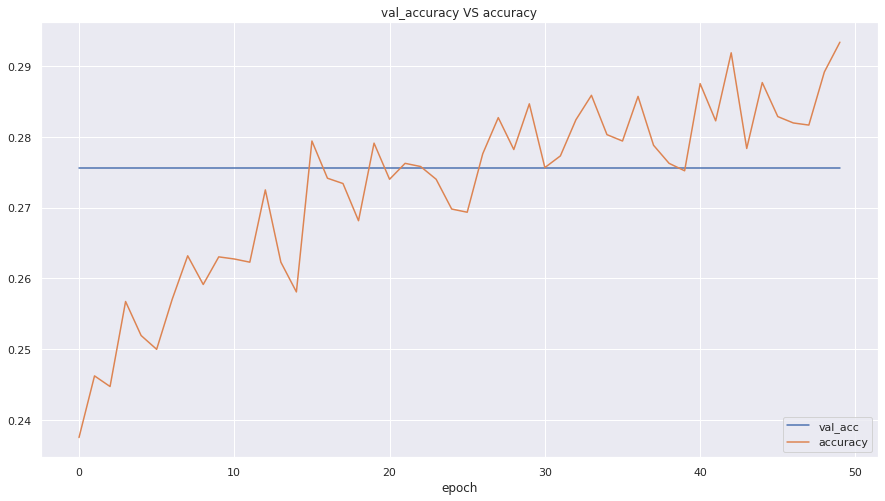

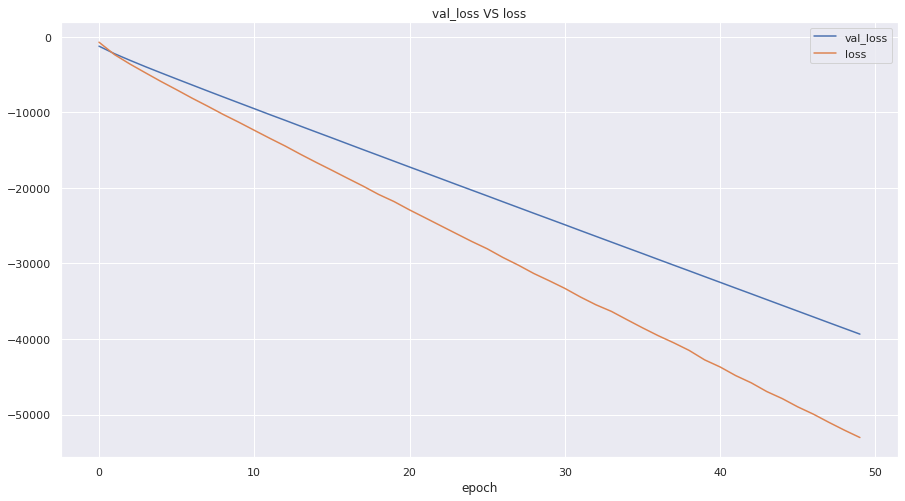

In [ ]:
from matplotlib import pyplot
pyplot.plot(history2.history['val_accuracy'])
pyplot.plot(history2.history['accuracy'])
pyplot.title('val_accuracy VS accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['val_acc', 'accuracy'], loc='lower right')
pyplot.show()

pyplot.plot(history2.history['val_loss'])
pyplot.plot(history2.history['loss'])
pyplot.title('val_loss VS loss')
pyplot.xlabel('epoch')
pyplot.legend(['val_loss', 'loss'], loc='upper right')
pyplot.show()

## MODEL 3 - GRU
### To solve the Vanishing-Exploding gradients problem often encountered during the operation of a basic **Recurrent Neural Network**, many variations were  eveloped. One of the most famous variations is the **Long Short Term Memory Network**(LSTM). One of the lesser-known but equally effective variations is the **Gated Recurrent Unit** Network(GRU).

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.3,random_state=0,shuffle=True)
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')


from keras import backend as K3
K3.clear_session()
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GRU

embedding_dim=200
latent_dim=200

#(x_train, y_train),(x_test, y_test) = Input(shape=(max_len_text,))
x_tr = sequence.pad_sequences(x_tr, maxlen=max_len_text, padding='post')
x_val = sequence.pad_sequences(x_val, maxlen=max_len_text, padding='post')
y_tr = np.asarray(y_tr).astype('float32')
y_var = np.asarray(y_val).astype('float32')

model3 = Sequential()
model3.add(Embedding(embedding_dim, latent_dim, input_length=max_len_text))

In [ ]:
model3.add(GRU(64))
model3.add(Dropout(0.5))
model3.add(Dense(10, activation='sigmoid'))

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
es3 = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)

In [ ]:
#SAVED_MODEL_PATH_3 = "/content/drive/MyDrive/Colab Notebooks/SavedModels/GRU"
#cbk3 = tkc.ModelCheckpoint(filepath=SAVED_MODEL_PATH_3, save_weights_only=False, monitor="loss", mode="min", save_best_only=True)

In [ ]:
history3=model3.fit(x_tr, y_tr, batch_size=128, epochs=50, validation_data=[x_val, y_val], callbacks=[es3])

Epoch 1/50
52/52 [==============================] - 5s 43ms/step - loss: -589.6190 - accuracy: 0.2566 - val_loss: -817.7636 - val_accuracy: 0.3475
Epoch 2/50
52/52 [==============================] - 2s 32ms/step - loss: -1406.8763 - accuracy: 0.2707 - val_loss: -1272.0938 - val_accuracy: 0.3475
Epoch 3/50
52/52 [==============================] - 2s 32ms/step - loss: -1989.5679 - accuracy: 0.2706 - val_loss: -1686.1233 - val_accuracy: 0.3475
Epoch 4/50
52/52 [==============================] - 2s 30ms/step - loss: -2544.3389 - accuracy: 0.2691 - val_loss: -2093.7056 - val_accuracy: 0.3475
Epoch 5/50
52/52 [==============================] - 2s 31ms/step - loss: -3101.0161 - accuracy: 0.2784 - val_loss: -2491.6372 - val_accuracy: 0.3475
Epoch 6/50
52/52 [==============================] - 1s 27ms/step - loss: -3641.7273 - accuracy: 0.2794 - val_loss: -2890.2820 - val_accuracy: 0.3475
Epoch 7/50
52/52 [==============================] - 1s 27ms/step - loss: -4170.3101 - accuracy: 0.2730 - val

In [ ]:
model3.save("/content/drive/MyDrive/Colab Notebooks/SavedModels/gru_keras_save.h5")

In [ ]:
from keras.models import load_model
model_gru = load_model("/content/drive/MyDrive/Colab Notebooks/SavedModels/gru_keras_save.h5")
model_gru.summary()
score3 = model_gru.evaluate(x_tr, y_tr, verbose=0)
print("%s: %.2f%%" % (model_gru.metrics_names[1], score3[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 90, 500)           100000    
                                                                 
 gru (GRU)                   (None, 64)                108672    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 209,322
Trainable params: 209,322
Non-trainable params: 0
_________________________________________________________________
accuracy: 30.12%


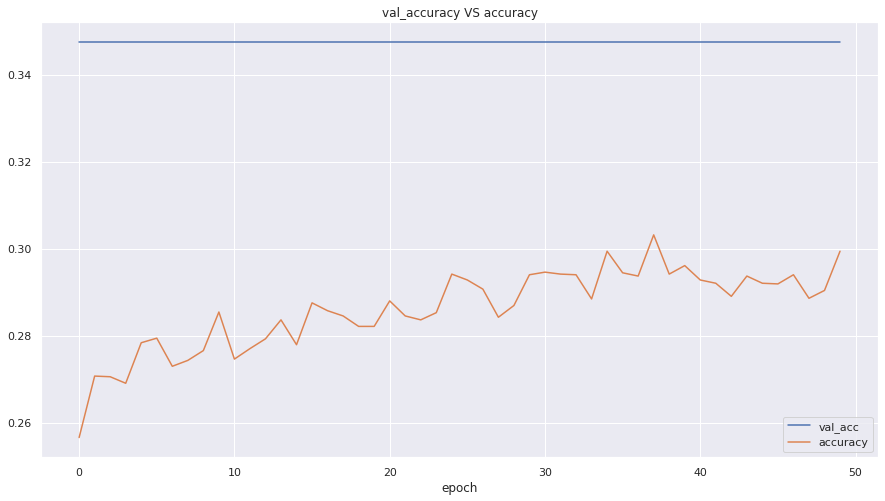

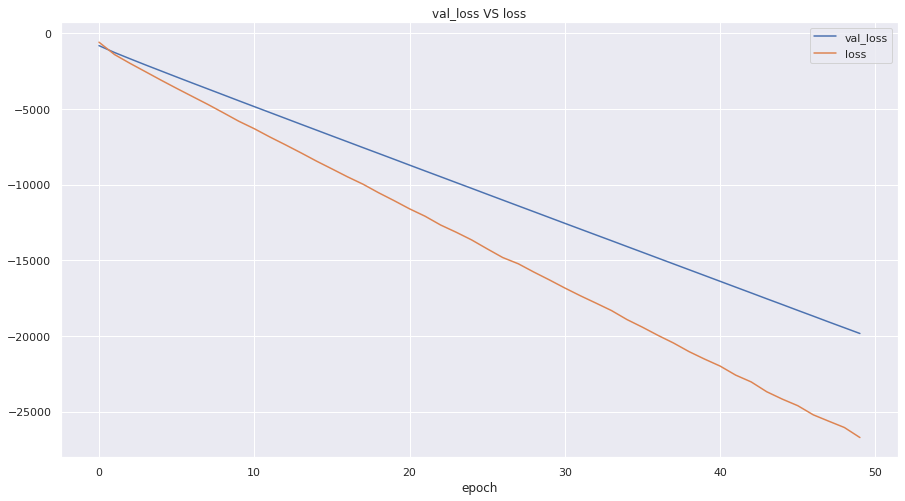

In [ ]:
from matplotlib import pyplot
pyplot.plot(history3.history['val_accuracy'])
pyplot.plot(history3.history['accuracy'])
pyplot.title('val_accuracy VS accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['val_acc', 'accuracy'], loc='lower right')
pyplot.show()

pyplot.plot(history3.history['val_loss'])
pyplot.plot(history3.history['loss'])
pyplot.title('val_loss VS loss')
pyplot.xlabel('epoch')
pyplot.legend(['val_loss', 'loss'], loc='upper right')
pyplot.show()